In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from matplotlib import pyplot
import seaborn as sns

from alignment import TrivialAlignment, CCA, ManifoldLinear#, manifold_nonlinear
from correspondence import Correspondence
from distance import SquaredL2
from neighborhood import neighbor_graph
from util import pairwise_error, Timer
from viz import show_alignment
from warping import manifold_warping_linear

from rpy2.robjects import r
import rpy2.robjects.pandas2ri as pandas2ri

In [2]:
file = "../../data/expr.RData"
rf = r['load'](file)

dayExpr = pandas2ri.ri2py_dataframe(r['dayExpr'])
nightExpr = pandas2ri.ri2py_dataframe(r['nightExpr'])

X = dayExpr.as_matrix()
Y = nightExpr.as_matrix()
n = 17695
d = 3

/home/dnguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/dnguyen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [3]:
X_normalized = preprocessing.normalize(X, norm='l2').T
Y_normalized = preprocessing.normalize(Y, norm='l2')[0:13, :].T

corr = Correspondence(matrix=np.eye(n))
Wx = neighbor_graph(X_normalized, k=3)
Wy = neighbor_graph(Y_normalized, k=3)

In [4]:
lin_aligners = (
    ('no alignment', lambda: TrivialAlignment(X_normalized, Y_normalized, d)),
    ('cca', lambda: CCA(X_normalized, Y_normalized, corr, d)),
    ('linear manifold', lambda: ManifoldLinear(X_normalized, Y_normalized, corr, d, Wx, Wy)),
    ('manifold warping', lambda: manifold_warping_linear(X_normalized, Y_normalized, d, Wx, Wy)[1]),
)

In [5]:
disMat = np.empty((0,313113025), float)
metric = SquaredL2

no alignment : 0.004 seconds
 sum sq. error = 1010.1441564836526
cca : 22.789 seconds
 sum sq. error = 93.06893094686065
linear manifold : 38.260 seconds
 sum sq. error = 128.4360997090435
manifold warping : 20.620 seconds


MemoryError: 

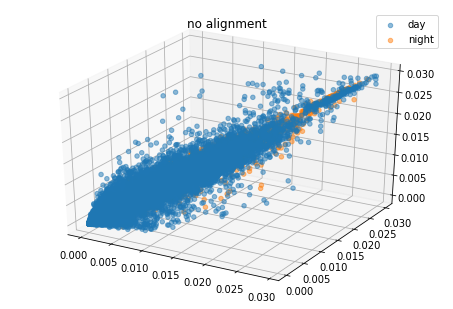

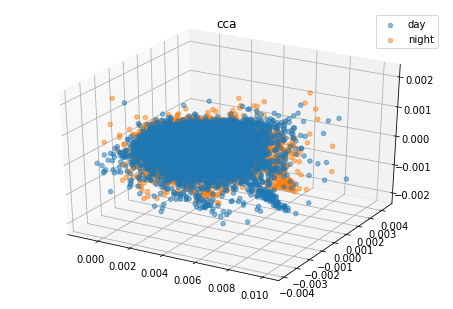

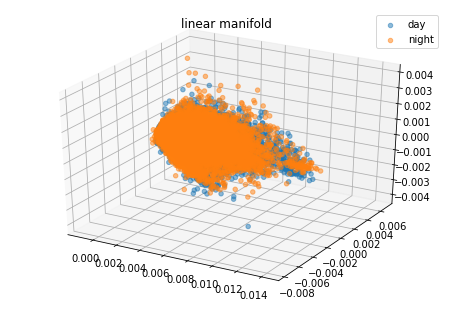

<Figure size 432x288 with 0 Axes>

In [6]:
for name, aln in lin_aligners:
    pyplot.figure()
    with Timer(name):
        Xnew, Ynew = aln().project(X_normalized, Y_normalized)
    print (' sum sq. error =', pairwise_error(Xnew, Ynew, metric=SquaredL2))
    show_alignment(Xnew, Ynew, 'day', 'night', name)
    pyplot.draw()
    
    disMat = np.vstack((disMat, metric.between(Xnew/Xnew.max(), Ynew/Ynew.max()).flatten()))

In [13]:
Xnew

array([[ 2.41164944e-03,  4.58416809e-04,  4.94770040e-04],
       [ 2.46817751e-03, -4.48410899e-04,  3.42449511e-04],
       [ 4.20836890e-03,  1.67298938e-03,  7.97387216e-05],
       ...,
       [ 2.69982772e-03,  1.43752789e-03, -2.50226234e-04],
       [ 2.91905664e-03,  1.10558408e-03, -5.72149263e-04],
       [ 2.92033683e-03,  6.70376349e-04, -5.57355265e-04]])

In [14]:
np.save("Xnew",Xnew)